In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [2]:
file_name = 'online_shoppers_intention.csv'
df = pd.read_csv(file_name)

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
print(df.isnull().sum())  

label_encoders = {}
categorical_cols = ['Month', 'VisitorType', 'Weekend']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


df['Revenue'] = df['Revenue'].astype(int)

X = df.drop('Revenue', axis=1)
y = df['Revenue']

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


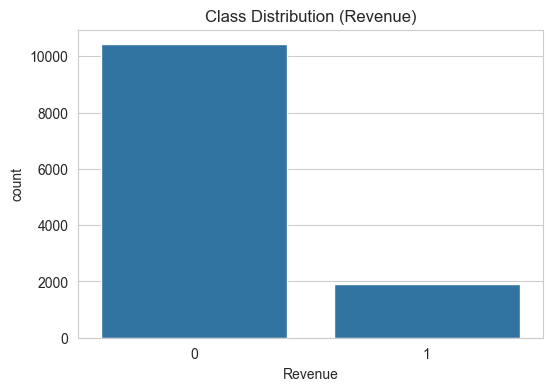

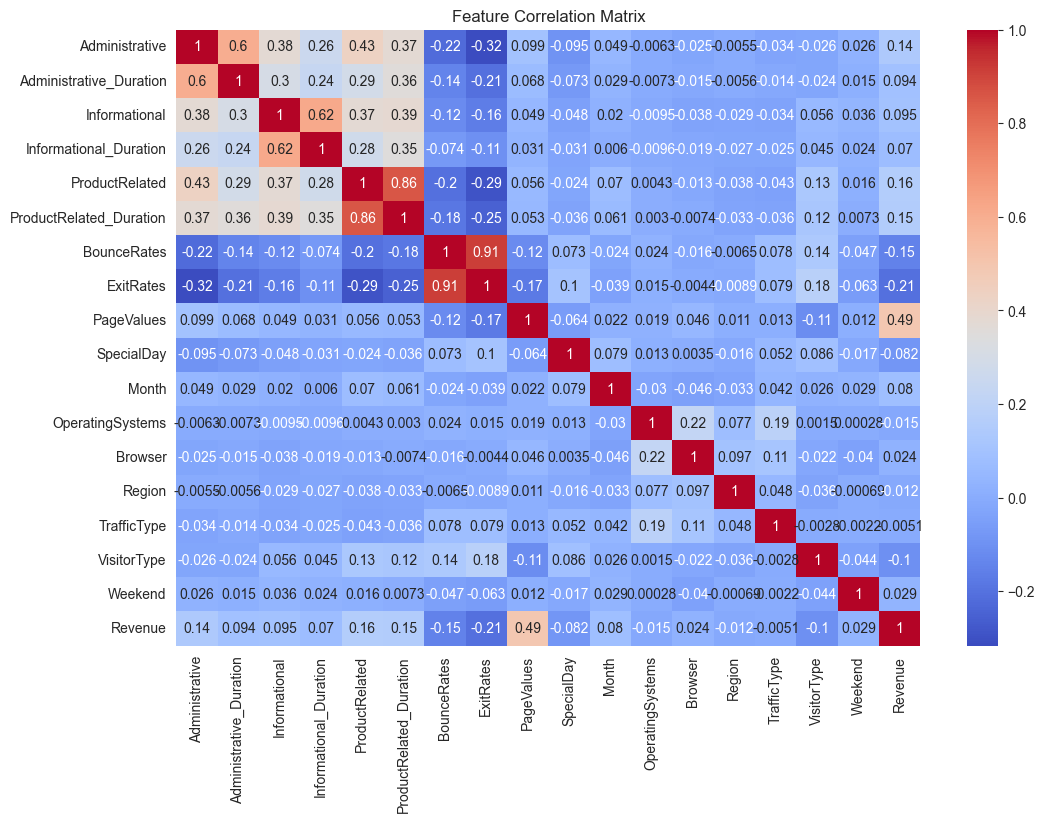

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Class Distribution (Revenue)')
plt.show()


plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

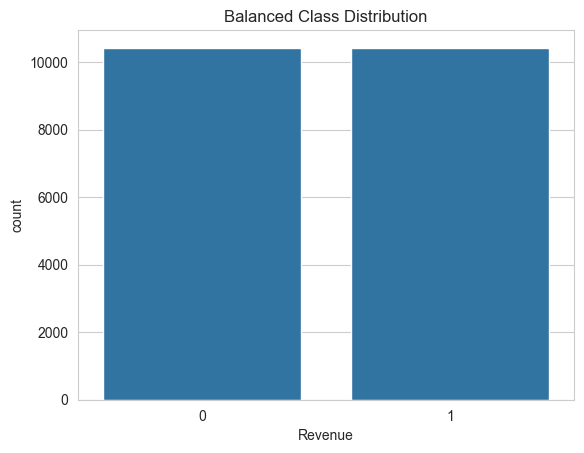

In [5]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

sns.countplot(x=y_resampled)
plt.title('Balanced Class Distribution')
plt.show()

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42
)

In [7]:
print(X_scaled)


[[-0.77977257 -0.52376001 -0.41954066 ... -0.77269514  0.54381367
  -0.44798576]
 [-0.77977257 -0.52376001 -0.41954066 ... -0.50261788  0.54381367
  -0.44798576]
 [-0.77977257 -0.52376001 -0.41954066 ... -0.23254062  0.54381367
  -0.44798576]
 ...
 [ 2.54406781  2.2229699  -0.41954066 ... -0.77269514  0.54381367
  -0.44798576]
 [ 0.12672935  0.49145146 -0.41954066 ... -0.50261788 -2.05661121
   2.23221379]
 [-0.47760526 -0.48271157 -0.41954066 ... -0.50261788  0.54381367
  -0.44798576]]


In [8]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2062
           1       0.91      0.95      0.93      2107

    accuracy                           0.93      4169
   macro avg       0.93      0.93      0.93      4169
weighted avg       0.93      0.93      0.93      4169



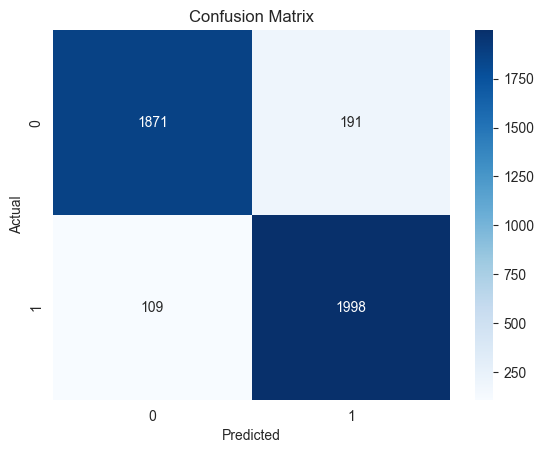

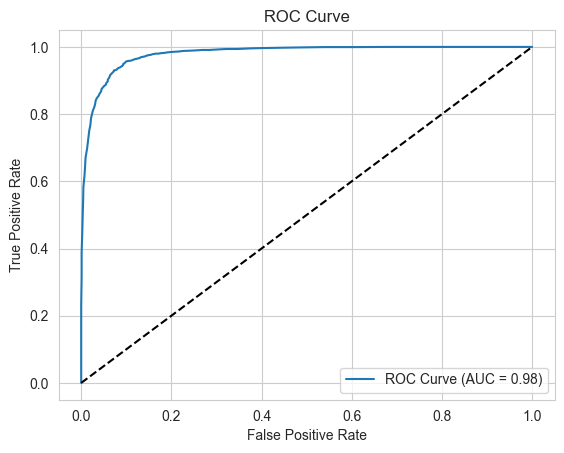

In [9]:
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

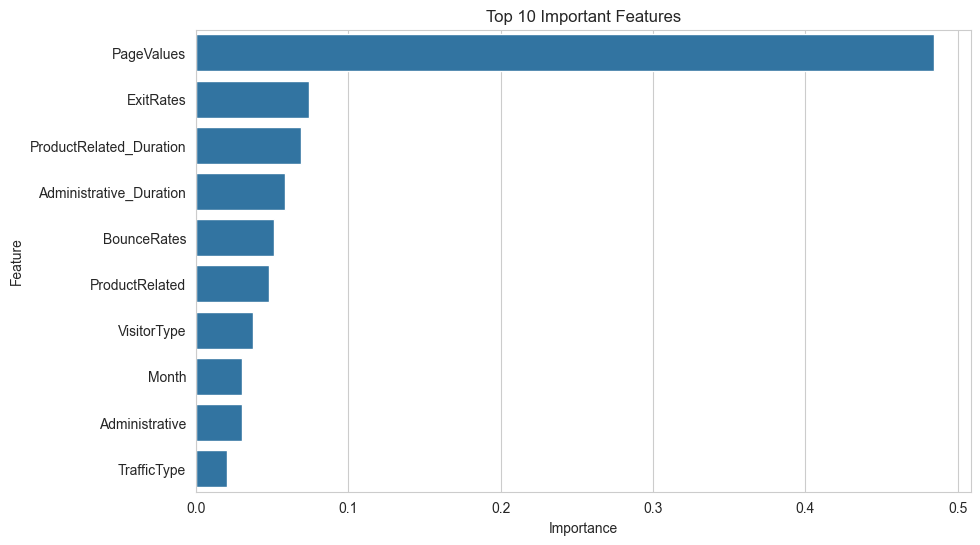

In [10]:
feature_importance = best_rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Important Features')
plt.show()

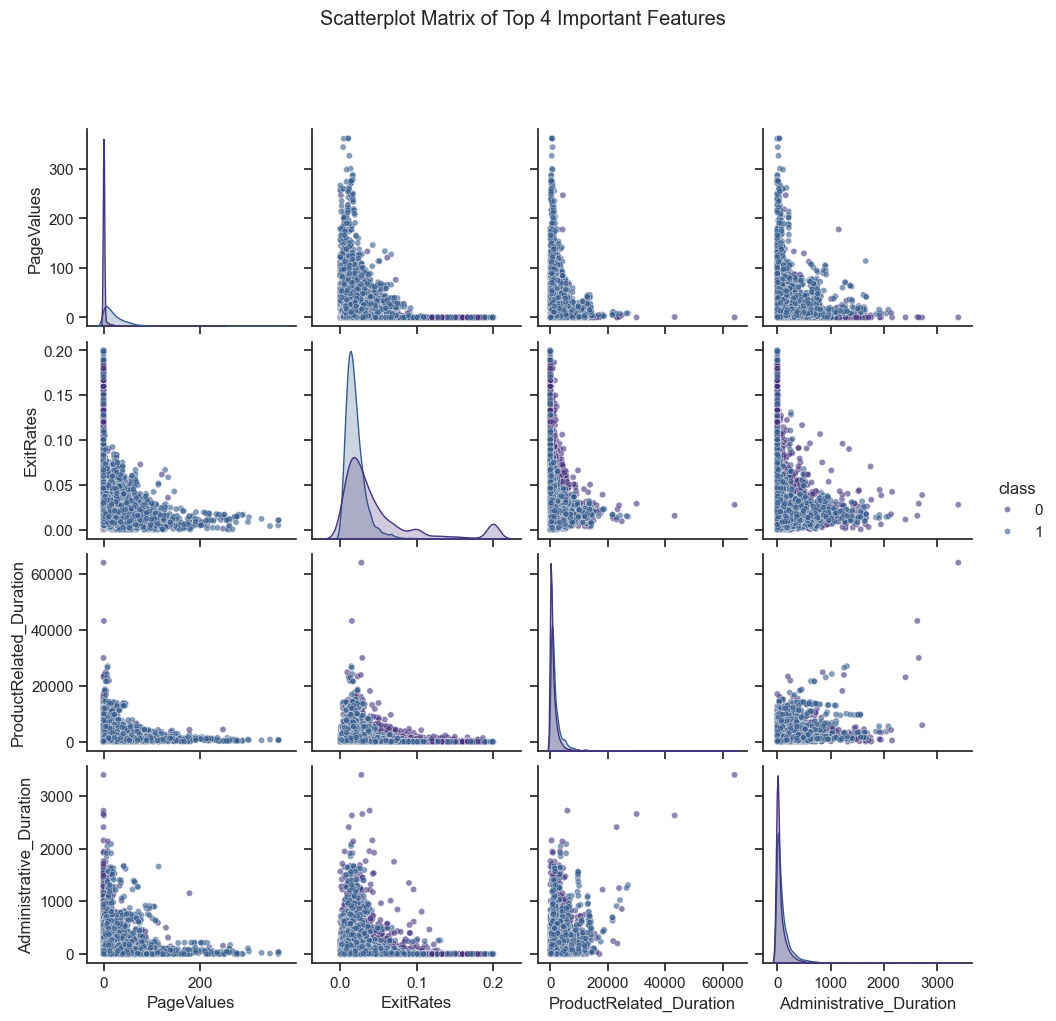

In [11]:
selected_features = ['PageValues', 'ExitRates', 'ProductRelated_Duration', 'Administrative_Duration']
data_plot = X_resampled[selected_features].copy()

data_plot['class'] = y_resampled

sns.set(style="ticks", palette="viridis")

grid = sns.pairplot(
    data_plot,
    hue='class',
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 20}, 
    height=2.5
)

plt.suptitle('Scatterplot Matrix of Top 4 Important Features', y=1.02)
grid.fig.subplots_adjust(top=0.9)  
plt.show()

SVM training time: 21.7845 seconds
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2062
           1       0.90      0.85      0.88      2107

    accuracy                           0.88      4169
   macro avg       0.88      0.88      0.88      4169
weighted avg       0.88      0.88      0.88      4169



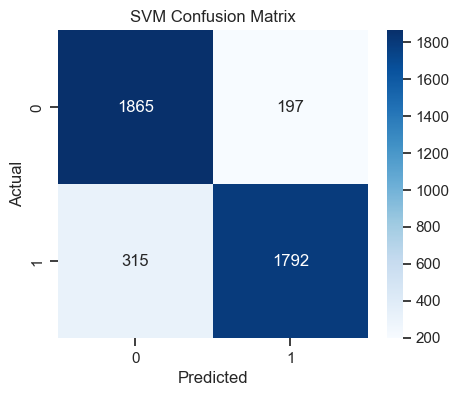

In [12]:
import time
from sklearn.svm import SVC

start_time_svm = time.time()
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)
end_time_svm = time.time()

training_time_svm = end_time_svm - start_time_svm
print("SVM training time: {:.4f} seconds".format(training_time_svm))

y_pred_svm = svm_clf.predict(X_test)
y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

svm_cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression training time: 0.0240 seconds
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2062
           1       0.88      0.79      0.83      2107

    accuracy                           0.84      4169
   macro avg       0.84      0.84      0.84      4169
weighted avg       0.84      0.84      0.84      4169



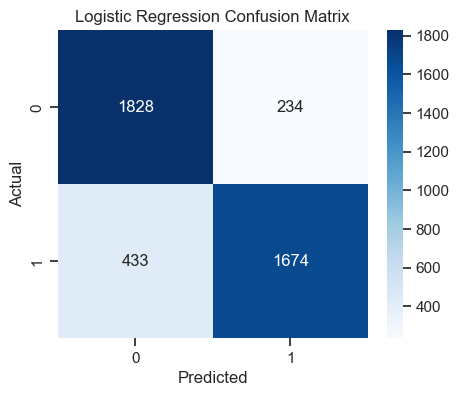

In [13]:
from sklearn.linear_model import LogisticRegression

start_time_lr = time.time()
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
end_time_lr = time.time()

training_time_lr = end_time_lr - start_time_lr
print("Logistic Regression training time: {:.4f} seconds".format(training_time_lr))

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

lr_cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

FFNN (MLPClassifier) training time: 5.6083 seconds
FFNN (MLPClassifier) Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2062
           1       0.89      0.91      0.90      2107

    accuracy                           0.90      4169
   macro avg       0.90      0.90      0.90      4169
weighted avg       0.90      0.90      0.90      4169



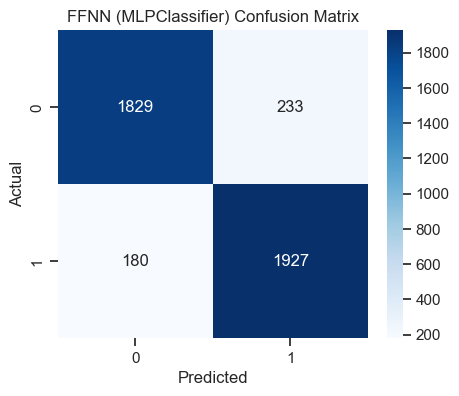

In [14]:

# FFNN（MLPClassifier）
from sklearn.neural_network import MLPClassifier

start_time_mlp = time.time()
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
end_time_mlp = time.time()

training_time_mlp = end_time_mlp - start_time_mlp
print("FFNN (MLPClassifier) training time: {:.4f} seconds".format(training_time_mlp))

y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

print("FFNN (MLPClassifier) Classification Report:")
print(classification_report(y_test, y_pred_mlp))

mlp_cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(5, 4))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues')
plt.title('FFNN (MLPClassifier) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:

# Training CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam


# Adaptive 1D convolution
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

model_cnn = Sequential()
Input(shape=(X_train.shape[1], 1)),
model_cnn.add(Conv1D(32, kernel_size=3, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

start_time_cnn = time.time()
history_cnn = model_cnn.fit(X_train_cnn, y_train,
                            epochs=10,
                            batch_size=32,
                            verbose=1)
end_time_cnn = time.time()

training_time_cnn = end_time_cnn - start_time_cnn
print("CNN training time: {:.4f} s".format(training_time_cnn))

Epoch 1/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7983 - loss: 0.4473
Epoch 2/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8622 - loss: 0.3373
Epoch 3/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8801 - loss: 0.2964
Epoch 4/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8908 - loss: 0.2837
Epoch 5/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8858 - loss: 0.2833
Epoch 6/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8904 - loss: 0.2716
Epoch 7/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8893 - loss: 0.2687
Epoch 8/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8993 - loss: 0.2542
Epoch 9/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9004 - loss: 0.2490
Epoch 10/10
522/522 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9025 - loss: 0.2493
CNN training time: 6.6038 s


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2062
           1       0.88      0.91      0.90      2107

    accuracy                           0.89      4169
   macro avg       0.90      0.89      0.89      4169
weighted avg       0.89      0.89      0.89      4169



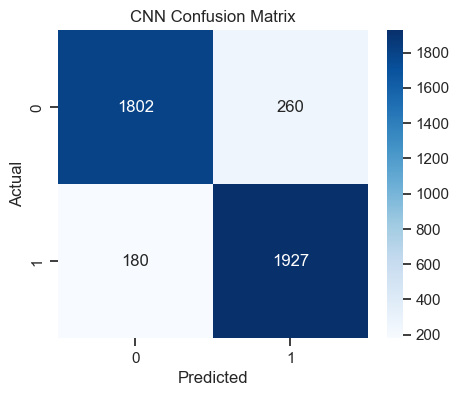

In [16]:

# rediction
y_proba_cnn = model_cnn.predict(X_test_cnn).ravel()
y_pred_cnn = (y_proba_cnn > 0.5).astype(int)

print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))

cnn_cm = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(5, 4))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

